<a href="https://colab.research.google.com/github/artificialsprit/deploy_ddsp/blob/main/easy_tone_transfer_0415.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DDSP Timbre Transfer Demo

This notebook is a demo of timbre transfer using DDSP (Differentiable Digital Signal Processing). 
The model here is trained to generate audio conditioned on a time series of fundamental frequency and loudness. 

* [DDSP ICLR paper](https://openreview.net/forum?id=B1x1ma4tDr)
* [Audio Examples](http://goo.gl/magenta/ddsp-examples) 

This notebook extracts these features from input audio (either uploaded files, or recorded from the microphone) and resynthesizes with the model. 

<img src="https://magenta.tensorflow.org/assets/ddsp/ddsp_cat_jamming.png" alt="DDSP Tone Transfer" width="700">



By default, the notebook will download pre-trained models. You can train a model on your own sounds by using the [Train Autoencoder Colab](https://github.com/magenta/ddsp/blob/master/ddsp/colab/demos/train_autoencoder.ipynb).

Have fun! And please feel free to hack this notebook to make your own creative interactions.


### Instructions for running:

* Make sure to use a GPU runtime, click:  __Runtime >> Change Runtime Type >> GPU__
* Press ▶️ on the left of each of the cells
* View the code: Double-click any of the cells
* Hide the code: Double click the right side of the cell





# Google Drive 연결  
- 각자 자신의 google drive 계정에 연결  
- 데이터 중간결과물에 있는 pretraining 모델 업로드 
: gjh_birds_my_solo_instrument  
: gjh_singingball_1_solo_instrument  
: pjy_insect_1_solo_instrument   
- pretraining 위치로 이동 : 자신의 구글 드라이브 위치에 맞게 myPath 부분 수정    

In [1]:
# 자신의 구글 드라이브에 모델 업로드 한 경로로 아래 위치 업데이트 하기!!! 
myPath = '/gdrive/MyDrive/Data/Sound_Synthesis/models/'

In [2]:
# 인증하기 
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


colab에서는 항상 필요한 패키지 매번 설치  

In [3]:
#@title #Install and Import

#@markdown Install ddsp, define some helper functions, and download the model. This transfers a lot of data and _should take a minute or two_.
%tensorflow_version 2.x
print('Installing from pip package...')
!pip install -qU ddsp==1.0.1

# Ignore a bunch of deprecation warnings
import warnings
warnings.filterwarnings("ignore")

import copy
import os
import time

import crepe
import ddsp
import ddsp.training
from ddsp.colab import colab_utils
from ddsp.colab.colab_utils import (
    auto_tune, detect_notes, fit_quantile_transform, 
    get_tuning_factor, download, play, record, 
    specplot, upload, DEFAULT_SAMPLE_RATE)
import gin
from google.colab import files
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

# Helper Functions
sample_rate = DEFAULT_SAMPLE_RATE  # 16000


print('Done!')

Installing from pip package...
     |████████████████████████████████| 174kB 6.7MB/s 
     |████████████████████████████████| 3.9MB 10.8MB/s 
     |████████████████████████████████| 215kB 45.8MB/s 
     |████████████████████████████████| 3.6MB 50.2MB/s 
     |████████████████████████████████| 92kB 12.8MB/s 
     |████████████████████████████████| 2.9MB 49.7MB/s 
     |████████████████████████████████| 378kB 38.0MB/s 
     |████████████████████████████████| 5.6MB 19.0MB/s 
     |████████████████████████████████| 20.2MB 1.6MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
ERROR: tensorflow 2.5.0 has requirement h5py~=3.1.0, but you'll have h5py 2.10.0 which is incompatible.


Done!


## Monopoly, Multipoly 파일 모두 사용할 수 있도록 수정  

In [4]:
#@title Record or Upload Audio
#@markdown * Either record audio from microphone or upload audio from file (.mp3 or .wav) 
#@markdown * Audio should be monophonic (single instrument / voice)
#@markdown * Extracts fundmanetal frequency (f0) and loudness features. 
flag = None

record_or_upload = "Upload (.mp3 or .wav)"  #@param ["Record", "Upload (.mp3 or .wav)"]

record_seconds =      20#@param {type:"number", min:1, max:10, step:1}

if record_or_upload == "Record":
  audio = record(seconds=record_seconds)
else:
  # Load audio sample here (.mp3 or .wav3 file)
  # Just use the first file.
  filenames, audios = upload()
  audio = audios[0]
  
  flag = 'multi' if audio.ndim==2 else 'mono'
  print(audio.shape)
  # monopoly : (352000,)  (1, 352000)
  # non-monopoly : 


Saving 202003294049_89bpm.mp3 to 202003294049_89bpm.mp3
(2, 3149741)


(3149741,)

Extracting audio features...


Audio features took 72.8 seconds


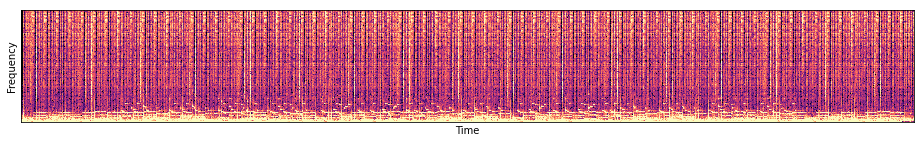

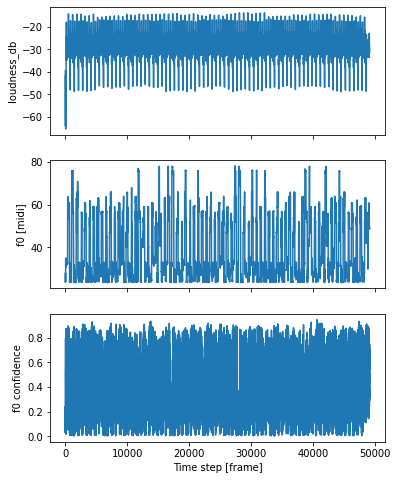

In [5]:
if flag == 'multi':
  audio = audio[0]
elif flag == 'mono':
  audio = audio[np.newaxis, :]

print(audio.shape)
print('\nExtracting audio features...')

# Plot.
specplot(audio)
play(audio)

# Setup the session.
ddsp.spectral_ops.reset_crepe()

# Compute features.
start_time = time.time()
audio_features = ddsp.training.metrics.compute_audio_features(audio)
audio_features['loudness_db'] = audio_features['loudness_db'].astype(np.float32)
audio_features_mod = None
print('Audio features took %.1f seconds' % (time.time() - start_time))


TRIM = -15
# Plot Features.
fig, ax = plt.subplots(nrows=3, 
                       ncols=1, 
                       sharex=True,
                       figsize=(6, 8))
ax[0].plot(audio_features['loudness_db'][:TRIM])
ax[0].set_ylabel('loudness_db')

ax[1].plot(librosa.hz_to_midi(audio_features['f0_hz'][:TRIM]))
ax[1].set_ylabel('f0 [midi]')

ax[2].plot(audio_features['f0_confidence'][:TRIM])
ax[2].set_ylabel('f0 confidence')
_ = ax[2].set_xlabel('Time step [frame]')



# 사전 준비  
- google drive의 데이터_중간결과물 models 폴더를 자신의 google drive에 복사  
- 복사한 폴더명  
- 아래에서 Load a model에서 원하는 모델 선택 후 실행    

## 파일 업로드 가능하도록 수정한 부분    
- #time_steps = int(audio.shape[1] / hop_size)  
- time_steps = int(audio.shape[0] / hop_size)  


In [6]:
#@title Load a model
#@markdown Run for ever new audio input
#model = 'Upload your own (checkpoint folder as .zip)' #@param ['Violin', 'Flute', 'Flute2', 'Trumpet', 'Tenor_Saxophone', 'Upload your own (checkpoint folder as .zip)']
model = 'Flute' #@param ['Violin', 'Flute', 'Flute2', 'Trumpet', 'Tenor_Saxophone', 'pjy_guitar', 'gjy_bottle', 'pdh_bell', 'pjy_water', 'pjy_water_mel', 'gjh_birds', 'gjh_singingball_1', 'pjy_insect_1', 'pjy_insect_2', 'pjy_dolphin'] 
#user model : 'Upload your own (checkpoint folder as .zip)', 
MODEL = model


def find_model_dir(dir_name):
  # Iterate through directories until model directory is found
  for root, dirs, filenames in os.walk(dir_name):
    for filename in filenames:
      if filename.endswith(".gin") and not filename.startswith("."):
        model_dir = root
        break
  return model_dir 

if model in ('Violin', 'Flute', 'Flute2', 'Trumpet', 'Tenor_Saxophone'):
  # Pretrained models.
  PRETRAINED_DIR = '/content/pretrained'
  # Copy over from gs:// for faster loading.
  !rm -r $PRETRAINED_DIR &> /dev/null
  !mkdir $PRETRAINED_DIR &> /dev/null
  GCS_CKPT_DIR = 'gs://ddsp/models/timbre_transfer_colab/2021-01-06'
  model_dir = os.path.join(GCS_CKPT_DIR, 'solo_%s_ckpt' % model.lower())
  
  !gsutil cp $model_dir/* $PRETRAINED_DIR &> /dev/null
  model_dir = PRETRAINED_DIR
  gin_file = os.path.join(model_dir, 'operative_config-0.gin')

else:
  if model == 'pjy_guitar':
    model_dir = myPath + 'pjy_guitar_my_solo_instrument'
  elif model == 'pjy_water':
    model_dir = myPath + 'pjy_water_my_solo_instrument'
  elif model == 'pdh_bell':
    model_dir = myPath + 'pdh_bell_my_solo_instrument'
  elif model == 'gjh_bottle':
    model_dir = myPath + 'gjh_bottle_my_solo_instrument'
  elif model == 'pjy_water_mel':
    model_dir = myPath + 'pjy_water_mel_my_solo_instrument'
  elif model == 'gjh_birds':
    model_dir = myPath + 'gjh_birds_my_solo_instrument'
  elif model == 'gjh_singingball_1':
    model_dir = myPath + 'gjh_singingball_1_solo_instrument'
  elif model == 'pjy_insect_1':
    model_dir = myPath + 'pjy_insect_1_solo_instrument'
  elif model == 'pjy_dolphin':
    model_dir = myPath + 'pjy_dolphin_solo_instrument'
  
  gin_file = os.path.join(model_dir, 'operative_config-0.gin')


# Load the dataset statistics.
DATASET_STATS = None
dataset_stats_file = os.path.join(model_dir, 'dataset_statistics.pkl')
print(f'Loading dataset statistics from {dataset_stats_file}')
try:
  if tf.io.gfile.exists(dataset_stats_file):
    with tf.io.gfile.GFile(dataset_stats_file, 'rb') as f:
      DATASET_STATS = pickle.load(f)
except Exception as err:
  print('Loading dataset statistics from pickle failed: {}.'.format(err))


# Parse gin config,
with gin.unlock_config():
  gin.parse_config_file(gin_file, skip_unknown=True)

# Assumes only one checkpoint in the folder, 'ckpt-[iter]`.
ckpt_files = [f for f in tf.io.gfile.listdir(model_dir) if 'ckpt' in f]
ckpt_name = ckpt_files[0].split('.')[0]
ckpt = os.path.join(model_dir, ckpt_name)

# Ensure dimensions and sampling rates are equal
time_steps_train = gin.query_parameter('F0LoudnessPreprocessor.time_steps')
n_samples_train = gin.query_parameter('Harmonic.n_samples')
hop_size = int(n_samples_train / time_steps_train)

if flag == 'mono':
  time_steps = int(audio.shape[1] / hop_size)
elif flag == 'multi':
  time_steps = int(audio.shape[0] / hop_size)

n_samples = time_steps * hop_size

print("===Trained model===")
print("Time Steps", time_steps_train)
print("Samples", n_samples_train)
print("Hop Size", hop_size)
print("\n===Resynthesis===")
print("Time Steps", time_steps)
print("Samples", n_samples)
print('')

gin_params = [
    'Harmonic.n_samples = {}'.format(n_samples),
    'FilteredNoise.n_samples = {}'.format(n_samples),
    'F0LoudnessPreprocessor.time_steps = {}'.format(time_steps),
    'oscillator_bank.use_angular_cumsum = True',  # Avoids cumsum accumulation errors.
]

with gin.unlock_config():
  gin.parse_config(gin_params)


# Trim all input vectors to correct lengths 
for key in ['f0_hz', 'f0_confidence', 'loudness_db']:
  audio_features[key] = audio_features[key][:time_steps]

if flag == 'mono':
  audio_features['audio'] = audio_features['audio'][:, :n_samples]
elif flag == 'multi': 
  audio_features['audio'] = audio_features['audio'][ :n_samples]


# Set up the model just to predict audio given new conditioning
model = ddsp.training.models.Autoencoder()
model.restore(ckpt)
print(audio_features)
# Build model by running a batch through it.
start_time = time.time()
_ = model(audio_features, training=False)
print('Restoring model took %.1f seconds' % (time.time() - start_time))

Loading dataset statistics from /content/pretrained/dataset_statistics.pkl
===Trained model===
Time Steps 1000
Samples 64000
Hop Size 64

===Resynthesis===
Time Steps 49214
Samples 3149696

{'audio': array([ 0.        ,  0.        ,  0.        , ..., -0.06946013,
       -0.03720206, -0.06845301], dtype=float32), 'loudness_db': array([-39.521545, -40.132652, -40.94357 , ..., -57.311214, -63.834415,
       -73.42529 ], dtype=float32), 'f0_hz': array([32.466595, 32.44789 , 32.342445, ...,  0.      ,  0.      ,
        0.      ], dtype=float32), 'f0_confidence': array([0.06859949, 0.0284567 , 0.04127811, ..., 1.        , 1.        ,
       1.        ], dtype=float32)}
Restoring model took 8.9 seconds


# 직접 생성한 모델로 여러가지 실험 해보기  

Autotuning... 
Inferred key: D  
Tuning offset: -1 cents


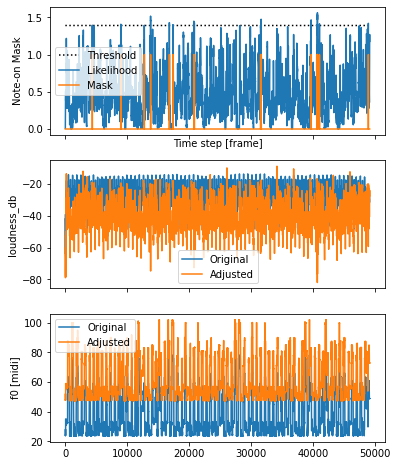

In [7]:
#@title Modify conditioning

#@markdown These models were not explicitly trained to perform timbre transfer, so they may sound unnatural if the incoming loudness and frequencies are very different then the training data (which will always be somewhat true). 


#@markdown ## Note Detection

#@markdown You can leave this at 1.0 for most cases
threshold = 1.39 #@param {type:"slider", min: 0.0, max:2.0, step:0.01}


#@markdown ## Automatic

ADJUST = True #@param{type:"boolean"}

#@markdown Quiet parts without notes detected (dB)
quiet = 21 #@param {type:"slider", min: 0, max:60, step:1}

#@markdown Force pitch to nearest note (amount)
autotune = 0.2 #@param {type:"slider", min: 0.0, max:1.0, step:0.1}

#@markdown ## Manual


#@markdown Shift the pitch (octaves)
pitch_shift =  0 #@param {type:"slider", min:-2, max:2, step:0.1}

#@markdown Adjsut the overall loudness (dB)
loudness_shift = 0 #@param {type:"slider", min:-20, max:20, step:1}


audio_features_mod = {k: v.copy() for k, v in audio_features.items()}


## Helper functions.
def shift_ld(audio_features, ld_shift=0.0):
  """Shift loudness by a number of ocatves."""
  audio_features['loudness_db'] += ld_shift
  return audio_features


def shift_f0(audio_features, pitch_shift=0.0):
  """Shift f0 by a number of ocatves."""
  audio_features['f0_hz'] *= 2.0 ** (pitch_shift)
  audio_features['f0_hz'] = np.clip(audio_features['f0_hz'], 
                                    0.0, 
                                    librosa.midi_to_hz(110.0))
  return audio_features


mask_on = None

if ADJUST and DATASET_STATS is not None:
  # Detect sections that are "on".
  mask_on, note_on_value = detect_notes(audio_features['loudness_db'],
                                        audio_features['f0_confidence'],
                                        threshold)

  if np.any(mask_on):
    # Shift the pitch register.
    target_mean_pitch = DATASET_STATS['mean_pitch']
    pitch = ddsp.core.hz_to_midi(audio_features['f0_hz'])
    mean_pitch = np.mean(pitch[mask_on])
    p_diff = target_mean_pitch - mean_pitch
    p_diff_octave = p_diff / 12.0
    round_fn = np.floor if p_diff_octave > 1.5 else np.ceil
    p_diff_octave = round_fn(p_diff_octave)
    audio_features_mod = shift_f0(audio_features_mod, p_diff_octave)


    # Quantile shift the note_on parts.
    _, loudness_norm = colab_utils.fit_quantile_transform(
        audio_features['loudness_db'],
        mask_on,
        inv_quantile=DATASET_STATS['quantile_transform'])

    # Turn down the note_off parts.
    mask_off = np.logical_not(mask_on)
    loudness_norm[mask_off] -=  quiet * (1.0 - note_on_value[mask_off][:, np.newaxis])
    loudness_norm = np.reshape(loudness_norm, audio_features['loudness_db'].shape)
    
    audio_features_mod['loudness_db'] = loudness_norm 

    # Auto-tune.
    if autotune:
      f0_midi = np.array(ddsp.core.hz_to_midi(audio_features_mod['f0_hz']))
      tuning_factor = get_tuning_factor(f0_midi, audio_features_mod['f0_confidence'], mask_on)
      f0_midi_at = auto_tune(f0_midi, tuning_factor, mask_on, amount=autotune)
      audio_features_mod['f0_hz'] = ddsp.core.midi_to_hz(f0_midi_at)

  else:
    print('\nSkipping auto-adjust (no notes detected or ADJUST box empty).')

else:
  print('\nSkipping auto-adujst (box not checked or no dataset statistics found).')

# Manual Shifts.
audio_features_mod = shift_ld(audio_features_mod, loudness_shift)
audio_features_mod = shift_f0(audio_features_mod, pitch_shift)



# Plot Features.
has_mask = int(mask_on is not None)
n_plots = 3 if has_mask else 2 
fig, axes = plt.subplots(nrows=n_plots, 
                      ncols=1, 
                      sharex=True,
                      figsize=(2*n_plots, 8))

if has_mask:
  ax = axes[0]
  ax.plot(np.ones_like(mask_on[:TRIM]) * threshold, 'k:')
  ax.plot(note_on_value[:TRIM])
  ax.plot(mask_on[:TRIM])
  ax.set_ylabel('Note-on Mask')
  ax.set_xlabel('Time step [frame]')
  ax.legend(['Threshold', 'Likelihood','Mask'])

ax = axes[0 + has_mask]
ax.plot(audio_features['loudness_db'][:TRIM])
ax.plot(audio_features_mod['loudness_db'][:TRIM])
ax.set_ylabel('loudness_db')
ax.legend(['Original','Adjusted'])

ax = axes[1 + has_mask]
ax.plot(librosa.hz_to_midi(audio_features['f0_hz'][:TRIM]))
ax.plot(librosa.hz_to_midi(audio_features_mod['f0_hz'][:TRIM]))
ax.set_ylabel('f0 [midi]')
_ = ax.legend(['Original','Adjusted'])


Prediction took 8.2 seconds
hi dict_keys(['_self_setattr_tracking', '_is_model_for_instrumentation', '_instrumented_keras_api', '_instrumented_keras_layer_class', '_instrumented_keras_model_class', '_trainable', '_stateful', 'built', '_input_spec', '_build_input_shape', '_saved_model_inputs_spec', '_supports_masking', '_name', '_activity_regularizer', '_trainable_weights', '_non_trainable_weights', '_updates', '_thread_local', '_callable_losses', '_losses', '_metrics', '_metrics_lock', '_dtype_policy', '_compute_dtype_object', '_autocast', '_self_tracked_trackables', '_inbound_nodes_value', '_outbound_nodes_value', '_expects_training_arg', '_default_training_arg', '_expects_mask_arg', '_dynamic', '_initial_weights', '_auto_track_sub_layers', '_preserve_input_structure_in_config', '_is_graph_network', 'inputs', 'outputs', 'input_names', 'output_names', 'stop_training', 'history', 'compiled_loss', 'compiled_metrics', '_compute_output_and_mask_jointly', '_is_compiled', 'optimizer', '_dist

Resynthesis


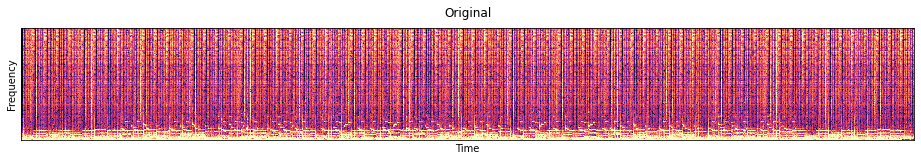

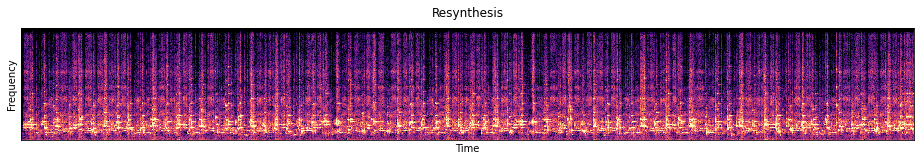

In [13]:
#@title #Resynthesize Audio

af = audio_features if audio_features_mod is None else audio_features_mod

# Run a batch of predictions.
start_time = time.time()
outputs = model(af, training=False)
audio_gen = model.get_audio_from_outputs(outputs)
print('Prediction took %.1f seconds' % (time.time() - start_time))
print('hi',vars(model).keys())
print('by', vars(audio_gen).keys())
print(type(audio_gen), type(audio))
# Plot
print('Original')
play(audio)

print('Resynthesis')
play(audio_gen)

specplot(audio)
plt.title("Original")

specplot(audio_gen)
_ = plt.title("Resynthesis")

In [22]:
import pydub

In [23]:
def write(f, sr, x, normalized=False):
    """numpy array to MP3"""
    channels = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
    if normalized:  # normalized array - each item should be a float in [-1, 1)
        y = np.int16(x * 2 ** 15)
    else:
        y = np.int16(x)
    song = pydub.AudioSegment(y.tobytes(), frame_rate=sr, sample_width=2, channels=channels)
    song.export(f, format="mp3", bitrate="320k")


In [24]:
write('new.mp3',16000, audio_gen, normalized=True)